In [5]:
# Cell 1: Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import random
import time
import kornia

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


In [6]:
# Cell 2: Model Definitions
print("Defining model architectures...")

class Block(nn.Module):
    def __init__(self, in_channels, filter_size, strides, kernel=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, filter_size, kernel, strides, kernel//2),
            nn.BatchNorm2d(filter_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):    
    def __init__(self, in_channels=2, out_channels=48, constant_feature_map=48):
        super().__init__()
        self.model = nn.Sequential(
            Block(in_channels, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, out_channels, 1)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):        
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(16, out_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, encoder_constant_features=48):
        super().__init__()
        self.encoder = Encoder(in_channels, encoder_constant_features, encoder_constant_features)
        self.decoder = Decoder(encoder_constant_features, out_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.model(x)

print("Model architectures defined successfully!")
print(f"Generator parameters: {sum(p.numel() for p in Generator().parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in Discriminator().parameters()):,}")

Defining model architectures...
Model architectures defined successfully!
Generator parameters: 298,385
Discriminator parameters: 2,756,801


In [7]:
# Cell 3: Dataset Class - UPDATED for CT-MRI dataset structure
print("Defining CT-MRI Dataset class...")

class CTMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=(256, 256)):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.img_size = img_size

        # Find all image pairs
        self.image_pairs = []

        print(f"Scanning dataset directory: {root_dir}")

        # Simple structure: root_dir/CT/ and root_dir/MRI/
        ct_dir = self.root_dir / 'CT'
        mri_dir = self.root_dir / 'MRI'

        # Check if both directories exist
        if ct_dir.exists() and mri_dir.exists():
            print("Found CT and MRI directories")

            # Get all PNG files from both directories
            ct_files = sorted(list(ct_dir.glob('*.png')))
            mri_files = sorted(list(mri_dir.glob('*.png')))

            print(f"Found {len(ct_files)} CT images and {len(mri_files)} MRI images")

            # Match files by name (they should have the same names)
            for ct_file in ct_files:
                mri_file = mri_dir / ct_file.name
                if mri_file.exists():
                    self.image_pairs.append((str(ct_file), str(mri_file)))
                else:
                    print(f"Warning: No matching MRI file for {ct_file.name}")

        else:
            print(f"Warning: Missing CT or MRI directory in {root_dir}")
            print(f"Expected: {ct_dir} and {mri_dir}")

        print(f"Found {len(self.image_pairs)} valid image pairs")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ct_path, mri_path = self.image_pairs[idx]

        try:
            # Load images
            ct_img = Image.open(ct_path).convert('RGB')
            mri_img = Image.open(mri_path).convert('RGB')

            # Convert to grayscale for fusion
            ct_gray = ct_img.convert('L')
            mri_gray = mri_img.convert('L')

            # Resize images
            ct_gray = ct_gray.resize(self.img_size, Image.Resampling.BILINEAR)
            mri_gray = mri_gray.resize(self.img_size, Image.Resampling.BILINEAR)

            # Convert to tensors and normalize to [-1, 1]
            if self.transform:
                ct_tensor = self.transform(ct_gray)
                mri_tensor = self.transform(mri_gray)
            else:
                ct_tensor = transforms.ToTensor()(ct_gray)
                mri_tensor = transforms.ToTensor()(mri_gray)
                ct_tensor = ct_tensor * 2.0 - 1.0
                mri_tensor = mri_tensor * 2.0 - 1.0

            return ct_tensor, mri_tensor

        except Exception as e:
            print(f"Error loading image pair {ct_path}, {mri_path}: {e}")
            # Return dummy data if there's an error
            dummy_img = torch.rand(1, self.img_size[0], self.img_size[1]) * 2 - 1
            return dummy_img, dummy_img

print("CT-MRI Dataset class defined successfully!")

Defining CT-MRI Dataset class...
CT-MRI Dataset class defined successfully!


In [8]:
# Cell 4: Training Utilities and Trainer Class - UPDATED save_sample_images method
print("Defining training utilities and trainer class...")

# Path configuration - Define early so they're available for class methods
RESULTS_DIR = "results/ddcgan_fusion"
SAMPLES_DIR = f"{RESULTS_DIR}/samples"
PLOTS_DIR = f"{RESULTS_DIR}/plots"
CHECKPOINTS_DIR = "checkpoints/intermediate/ddcgan_fusion"
FINAL_MODELS_DIR = "checkpoints/final/ddcgan_fusion"

def weights_init(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Calculate gradient penalty for WGAN-GP"""
    batch_size = real_samples.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class DDcGANTrainer:
    def __init__(self, dataset_path, batch_size=8, lr=0.0002, img_size=(256, 256), device='cuda'):
        self.device = device
        self.batch_size = batch_size
        self.img_size = img_size
        
        print(f"Initializing trainer with batch_size={batch_size}, lr={lr}, img_size={img_size}")
        
        # Data preparation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])
        
        print("Loading dataset...")
        self.dataset = CTMRIDataset(dataset_path, transform=transform, img_size=img_size)
        self.dataloader = DataLoader(
            self.dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4,
            pin_memory=True
        )
        
        print("Initializing models...")
        # Initialize models
        self.generator = Generator(in_channels=2, out_channels=1).to(device)
        self.discriminator1 = Discriminator(in_channels=1).to(device)  # Global discriminator
        self.discriminator2 = Discriminator(in_channels=1).to(device)  # Local discriminator
        
        # Apply weight initialization
        self.generator.apply(weights_init)
        self.discriminator1.apply(weights_init)
        self.discriminator2.apply(weights_init)
        
        print("Initializing optimizers...")
        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d1_optimizer = optim.Adam(self.discriminator1.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d2_optimizer = optim.Adam(self.discriminator2.parameters(), lr=lr, betas=(0.5, 0.999))
        
        # Loss functions
        self.adversarial_loss = nn.MSELoss()
        self.reconstruction_loss = nn.L1Loss()
        
        # Loss weights
        self.lambda_recon = 100.0
        self.lambda_gp = 10.0
        
        # Training history
        self.g_losses = []
        self.d_losses = []
        self.recon_losses = []
        self.g_adv_losses = []
        self.d1_losses = []
        self.d2_losses = []
        self.epoch_times = []
        
        print("Trainer initialized successfully!")
        
    def gradient_loss(self, gen_img, ir_img):
        """Force generator to keep IR edges"""
        gen_grad = kornia.filters.sobel(gen_img)
        ir_grad = kornia.filters.sobel(ir_img)
        return torch.nn.functional.l1_loss(gen_grad, ir_grad)

    def ssim_loss(self, img1, img2):
        """SSIM-based similarity loss"""
        ssim_fn = kornia.losses.SSIMLoss(window_size=11, reduction='mean')
        return ssim_fn(img1, img2)
        
    def train_epoch(self, epoch):
        start_time = time.time()
        self.generator.train()
        self.discriminator1.train()
        self.discriminator2.train()
        
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_recon_loss = 0
        epoch_g_adv_loss = 0
        epoch_d1_loss = 0
        epoch_d2_loss = 0
        epoch_ir_loss = 0
        epoch_ssim_loss = 0

        
        pbar = tqdm(self.dataloader, desc=f'Epoch {epoch}')
        
        for i, (ct_imgs, mri_imgs) in enumerate(pbar):
            batch_size = ct_imgs.size(0)
            ct_imgs = ct_imgs.to(self.device)
            mri_imgs = mri_imgs.to(self.device)
            
            # Concatenate CT and MRI images as input
            input_imgs = torch.cat([ct_imgs, mri_imgs], dim=1)
            
            # Real and fake labels
            real_label = torch.ones(batch_size, 1).to(self.device)
            fake_label = torch.zeros(batch_size, 1).to(self.device)
            
            # ---------------------
            # Train Discriminators
            # ---------------------
            
            # Generate fake fused images
            with torch.no_grad():
                fake_fused = self.generator(input_imgs)
            
            # Create "real" fused images (using CT as reference for now)
            real_fused = ct_imgs
            
            # Train Discriminator 1 (Global)
            self.d1_optimizer.zero_grad()
            
            real_pred1 = self.discriminator1(real_fused)
            fake_pred1 = self.discriminator1(fake_fused.detach())
            
            d1_real_loss = self.adversarial_loss(real_pred1, real_label)
            d1_fake_loss = self.adversarial_loss(fake_pred1, fake_label)
            d1_loss = (d1_real_loss + d1_fake_loss) / 2
            
            d1_loss.backward()
            self.d1_optimizer.step()
            
            # Train Discriminator 2 (Local/Detail)
            self.d2_optimizer.zero_grad()
            
            real_pred2 = self.discriminator2(real_fused)
            fake_pred2 = self.discriminator2(fake_fused.detach())
            
            d2_real_loss = self.adversarial_loss(real_pred2, real_label)
            d2_fake_loss = self.adversarial_loss(fake_pred2, fake_label)
            d2_loss = (d2_real_loss + d2_fake_loss) / 2
            
            d2_loss.backward()
            self.d2_optimizer.step()
            
            total_d_loss = d1_loss + d2_loss
            
            # -----------------
            # Train Generator
            # -----------------
            
            self.g_optimizer.zero_grad()
            
            # Generate fused images
            fused_imgs = self.generator(input_imgs)
            
            # Adversarial losses
            pred1 = self.discriminator1(fused_imgs)
            pred2 = self.discriminator2(fused_imgs)
            
            g_adv_loss1 = self.adversarial_loss(pred1, real_label)
            g_adv_loss2 = self.adversarial_loss(pred2, real_label)
            g_adv_loss = (g_adv_loss1 + g_adv_loss2) / 2
            
            # Reconstruction loss (preserve CT + MRI equally)
            g_recon_loss = self.reconstruction_loss(fused_imgs, ct_imgs) + \
                           self.reconstruction_loss(fused_imgs, mri_imgs)
            
            # MRI gradient-preserving loss
            g_ir_loss = self.gradient_loss(fused_imgs, mri_imgs)
            
            # SSIM loss (structural preservation)
            g_ssim_loss = self.ssim_loss(fused_imgs, ct_imgs) + \
                          self.ssim_loss(fused_imgs, mri_imgs)
            
            # Total generator loss with weights
            g_loss = g_adv_loss + \
                     10.0 * g_recon_loss + \
                     5.0 * g_ir_loss + \
                     1.0 * g_ssim_loss

            
            g_loss.backward()
            self.g_optimizer.step()
            
            # Update losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += total_d_loss.item()
            epoch_recon_loss += g_recon_loss.item()
            epoch_g_adv_loss += g_adv_loss.item()
            epoch_ir_loss += g_ir_loss.item()
            epoch_ssim_loss += g_ssim_loss.item()
            epoch_d1_loss += d1_loss.item()
            epoch_d2_loss += d2_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{total_d_loss.item():.4f}',
                'Recon_Loss': f'{g_recon_loss.item():.4f}',
                'G_Adv_Loss': f'{g_adv_loss.item():.4f}',
                'D1_Loss': f'{d1_loss.item():.4f}',
                'D2_Loss': f'{d2_loss.item():.4f}'
            })
            
            # Save sample images every 100 batches
            if i % 100 == 0:
                self.save_sample_images(ct_imgs, mri_imgs, fused_imgs, epoch, i)
        
        # Calculate epoch averages
        avg_g_loss = epoch_g_loss / len(self.dataloader)
        avg_d_loss = epoch_d_loss / len(self.dataloader)
        avg_recon_loss = epoch_recon_loss / len(self.dataloader)
        avg_g_adv_loss = epoch_g_adv_loss / len(self.dataloader)
        avg_ir_loss = epoch_ir_loss / len(self.dataloader)
        avg_ssim_loss = epoch_ssim_loss / len(self.dataloader)
        avg_d1_loss = epoch_d1_loss / len(self.dataloader)
        avg_d2_loss = epoch_d2_loss / len(self.dataloader)
        epoch_time = time.time() - start_time
        
        # Store metrics
        self.g_losses.append(avg_g_loss)
        self.d_losses.append(avg_d_loss)
        self.recon_losses.append(avg_recon_loss)
        self.g_adv_losses.append(avg_g_adv_loss)
        self.d1_losses.append(avg_d1_loss)
        self.d2_losses.append(avg_d2_loss)
        self.epoch_times.append(epoch_time)
        
        # Print epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"  Generator Loss: {avg_g_loss:.4f}")
        print(f"  Discriminator Loss: {avg_d_loss:.4f}")
        print(f"  Reconstruction Loss: {avg_recon_loss:.4f}")
        print(f"  Generator Adversarial Loss: {avg_g_adv_loss:.4f}")
        print(f"  Discriminator 1 Loss: {avg_d1_loss:.4f}")
        print(f"  Discriminator 2 Loss: {avg_d2_loss:.4f}")
        print(f"  Epoch Time: {epoch_time:.2f} seconds")
        print(f"  MRI Loss: {avg_ir_loss:.4f}")
        print(f"  SSIM Loss: {avg_ssim_loss:.4f}")

        
        return avg_g_loss, avg_d_loss
    
    def save_sample_images(self, ct_imgs, mri_imgs, fused_imgs, epoch, batch_idx):
        """Save sample images during training"""
        os.makedirs(SAMPLES_DIR, exist_ok=True)
        
        # Take first image from batch
        ct_sample = ct_imgs[0].cpu()
        mri_sample = mri_imgs[0].cpu()
        fused_sample = fused_imgs[0].cpu()
        
        # Denormalize images and convert to numpy
        ct_sample = (ct_sample + 1) / 2
        mri_sample = (mri_sample + 1) / 2
        fused_sample = (fused_sample + 1) / 2
        
        # Convert to numpy arrays and ensure proper shape
        ct_np = ct_sample.squeeze().detach().cpu().numpy()
        mri_np = mri_sample.squeeze().detach().cpu().numpy()
        fused_np = fused_sample.squeeze().detach().cpu().numpy()
        
        # Ensure 2D arrays for grayscale
        if len(ct_np.shape) == 3 and ct_np.shape[0] == 1:
            ct_np = ct_np[0]
        if len(mri_np.shape) == 3 and mri_np.shape[0] == 1:
            mri_np = mri_np[0]
        if len(fused_np.shape) == 3 and fused_np.shape[0] == 1:
            fused_np = fused_np[0]
        
        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(ct_np, cmap='gray')
        axes[0].set_title('CT')
        axes[0].axis('off')
        
        axes[1].imshow(mri_np, cmap='gray')
        axes[1].set_title('MRI')
        axes[1].axis('off')
        
        axes[2].imshow(fused_np, cmap='gray')
        axes[2].set_title('Fused')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{SAMPLES_DIR}/epoch_{epoch}_batch_{batch_idx}.png', dpi=150, bbox_inches='tight')
        plt.close()
    
    def save_model(self, epoch, path=CHECKPOINTS_DIR):
        """Save model checkpoints"""
        os.makedirs(path, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator1_state_dict': self.discriminator1.state_dict(),
            'discriminator2_state_dict': self.discriminator2.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd1_optimizer_state_dict': self.d1_optimizer.state_dict(),
            'd2_optimizer_state_dict': self.d2_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
            'recon_losses': self.recon_losses,
            'g_adv_losses': self.g_adv_losses,
            'd1_losses': self.d1_losses,
            'd2_losses': self.d2_losses,
            'epoch_times': self.epoch_times
        }
        
        torch.save(checkpoint, f'{path}/ddcgan_epoch_{epoch}.pth')
        print(f'Model saved at epoch {epoch}')
    
    def load_model(self, checkpoint_path):
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator1.load_state_dict(checkpoint['discriminator1_state_dict'])
        self.discriminator2.load_state_dict(checkpoint['discriminator2_state_dict'])
        
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d1_optimizer.load_state_dict(checkpoint['d1_optimizer_state_dict'])
        self.d2_optimizer.load_state_dict(checkpoint['d2_optimizer_state_dict'])
        
        self.g_losses = checkpoint['g_losses']
        self.d_losses = checkpoint['d_losses']
        self.recon_losses = checkpoint['recon_losses']
        self.g_adv_losses = checkpoint['g_adv_losses']
        self.d1_losses = checkpoint['d1_losses']
        self.d2_losses = checkpoint['d2_losses']
        self.epoch_times = checkpoint['epoch_times']
        
        return checkpoint['epoch']
    
    def train(self, num_epochs, save_interval=5):
        """Main training loop"""
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Dataset size: {len(self.dataset)} image pairs")
        print(f"Batch size: {self.batch_size}")
        print(f"Device: {self.device}")
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            g_loss, d_loss = self.train_epoch(epoch + 1)
            
            print(f'Epoch [{epoch+1}/{num_epochs}] - G_Loss: {g_loss:.4f}, D_Loss: {d_loss:.4f}')
            
            # Save model checkpoint
            if (epoch + 1) % save_interval == 0:
                self.save_model(epoch + 1)
        
        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.2f} seconds!")
        
        # Plot training losses
        self.plot_training_metrics()
    
    def plot_training_metrics(self):
        """Plot all training metrics"""
        os.makedirs(PLOTS_DIR, exist_ok=True)
        
        epochs = range(1, len(self.g_losses) + 1)
        
        # Plot 1: Generator and Discriminator losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.g_losses, label='Generator Loss')
        plt.plot(epochs, self.d_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Generator vs Discriminator Loss')
        
        # Plot 2: Component losses
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.recon_losses, label='Reconstruction Loss')
        plt.plot(epochs, self.g_adv_losses, label='Generator Adv Loss')
        plt.plot(epochs, self.d1_losses, label='Discriminator 1 Loss')
        plt.plot(epochs, self.d2_losses, label='Discriminator 2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Component Losses')
        
        plt.tight_layout()
        plt.savefig(f'{PLOTS_DIR}/training_losses.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Plot 3: Epoch times
        plt.figure(figsize=(8, 4))
        plt.plot(epochs, self.epoch_times)
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')
        plt.title('Epoch Training Time')
        plt.savefig(f'{PLOTS_DIR}/epoch_times.png', dpi=150, bbox_inches='tight')
        plt.show()

print("Training utilities and trainer class defined successfully!")

Defining training utilities and trainer class...
Training utilities and trainer class defined successfully!


In [ ]:
# Cell 5: Dataset Preparation and Setup - UPDATED configuration
print("Setting up dataset and training configuration...")

# Configuration - Updated for CT-MRI dataset
BATCH_SIZE = 16  # Increased since we have more data
LEARNING_RATE = 0.0002
NUM_EPOCHS = 50
IMG_SIZE = (256, 256)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_PATH = "../Dataset/CT-MRI"

# Create necessary directories (paths already defined in Cell 4)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FINAL_MODELS_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Dataset path: {DATASET_PATH}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Samples directory: {SAMPLES_DIR}")
print(f"Plots directory: {PLOTS_DIR}")
print(f"Checkpoints directory: {CHECKPOINTS_DIR}")
print(f"Final models directory: {FINAL_MODELS_DIR}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Image size: {IMG_SIZE}")

Setting up dataset and training configuration...
Using device: cuda
Dataset path: ../Dataset/CT-MRI
Results directory: results/ddcgan_fusion
Samples directory: results/ddcgan_fusion/samples
Plots directory: results/ddcgan_fusion/plots
Checkpoints directory: checkpoints/intermediate/ddcgan_fusion
Final models directory: checkpoints/final/ddcgan_fusion
Batch size: 16
Learning rate: 0.0002
Number of epochs: 3
Image size: (256, 256)


Starting model training...
Initializing trainer with batch_size=16, lr=0.0002, img_size=(256, 256)
Loading dataset...
Scanning dataset directory: ../Dataset/CT-MRI
Found CT and MRI directories
Found 573 CT images and 573 MRI images
Found 573 valid image pairs
Initializing models...
Initializing optimizers...
Trainer initialized successfully!
Trainer created successfully. Starting training...
Starting training for 3 epochs...
Dataset size: 573 image pairs
Batch size: 16
Device: cuda
Initializing optimizers...
Trainer initialized successfully!
Trainer created successfully. Starting training...
Starting training for 3 epochs...
Dataset size: 573 image pairs
Batch size: 16
Device: cuda


Epoch 1: 100%|██████████| 36/36 [00:12<00:00,  2.91it/s, G_Loss=8.7552, D_Loss=0.0769, Recon_Loss=0.7079, G_Adv_Loss=0.8457, D1_Loss=0.0369, D2_Loss=0.0400]



Epoch 1 Summary:
  Generator Loss: 11.3856
  Discriminator Loss: 0.2410
  Reconstruction Loss: 0.9704
  Generator Adversarial Loss: 0.7108
  Discriminator 1 Loss: 0.1453
  Discriminator 2 Loss: 0.0957
  Epoch Time: 12.39 seconds
  MRI Loss: 0.0452
  SSIM Loss: 0.7446
Epoch [1/3] - G_Loss: 11.3856, D_Loss: 0.2410


Epoch 2: 100%|██████████| 36/36 [00:11<00:00,  3.02it/s, G_Loss=6.7988, D_Loss=0.3724, Recon_Loss=0.5351, G_Adv_Loss=0.7022, D1_Loss=0.2484, D2_Loss=0.1240]



Epoch 2 Summary:
  Generator Loss: 7.6688
  Discriminator Loss: 0.1630
  Reconstruction Loss: 0.6170
  Generator Adversarial Loss: 0.7161
  Discriminator 1 Loss: 0.0819
  Discriminator 2 Loss: 0.0811
  Epoch Time: 11.92 seconds
  MRI Loss: 0.0472
  SSIM Loss: 0.5465
Epoch [2/3] - G_Loss: 7.6688, D_Loss: 0.1630


Epoch 3: 100%|██████████| 36/36 [00:11<00:00,  3.06it/s, G_Loss=5.4350, D_Loss=0.3021, Recon_Loss=0.4393, G_Adv_Loss=0.3588, D1_Loss=0.1390, D2_Loss=0.1631]




Epoch 3 Summary:
  Generator Loss: 6.3024
  Discriminator Loss: 0.2440
  Reconstruction Loss: 0.4991
  Generator Adversarial Loss: 0.5708
  Discriminator 1 Loss: 0.1247
  Discriminator 2 Loss: 0.1193
  Epoch Time: 11.76 seconds
  MRI Loss: 0.0497
  SSIM Loss: 0.4925
Epoch [3/3] - G_Loss: 6.3024, D_Loss: 0.2440
Training completed in 36.07 seconds!


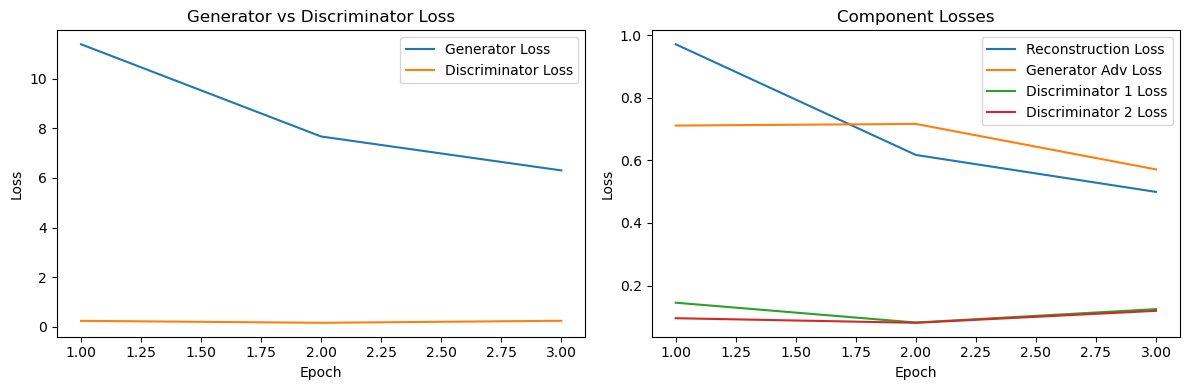

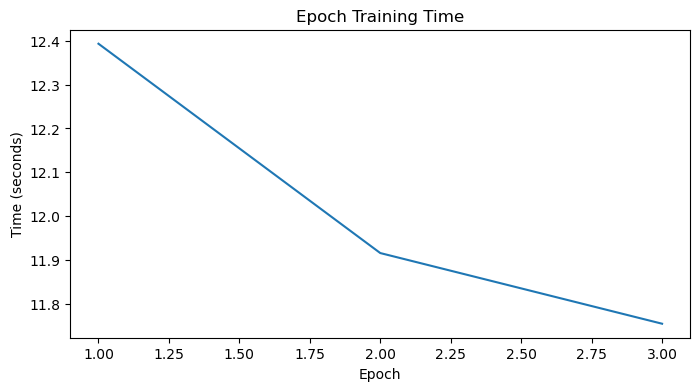

Model saved at epoch 3
Training completed successfully!
Model checkpoints saved in: checkpoints/intermediate/ddcgan_fusion
Final model saved in: checkpoints/final/ddcgan_fusion
Sample images saved in: results/ddcgan_fusion/samples
Training plots saved in: results/ddcgan_fusion/plots


In [10]:
print("Starting model training...")

# Only run if dataset is available
if DATASET_PATH and os.path.exists(DATASET_PATH):
    try:
        # Create trainer
        trainer = DDcGANTrainer(
            dataset_path=DATASET_PATH,
            batch_size=BATCH_SIZE,
            lr=LEARNING_RATE,
            img_size=IMG_SIZE,
            device=DEVICE
        )
        
        print("Trainer created successfully. Starting training...")
        
        # Start training
        trainer.train(NUM_EPOCHS, save_interval=10)
        
        # Save final model
        trainer.save_model(NUM_EPOCHS, FINAL_MODELS_DIR)
        
        print("Training completed successfully!")
        print(f"Model checkpoints saved in: {CHECKPOINTS_DIR}")
        print(f"Final model saved in: {FINAL_MODELS_DIR}")
        print(f"Sample images saved in: {SAMPLES_DIR}")
        print(f"Training plots saved in: {PLOTS_DIR}")
        
    except Exception as e:
        print(f"Error during training: {e}")
        print("Training failed. Please check the dataset path and format.")
        import traceback
        traceback.print_exc()
else:
    print("Dataset not available. Please ensure the KAIST dataset is properly set up.")
    

Setting up demonstration and testing...
Found checkpoint: checkpoints/final/ddcgan_fusion/ddcgan_epoch_3.pth
✓ Loaded model from checkpoints/final/ddcgan_fusion/ddcgan_epoch_3.pth
Scanning dataset directory: ../Dataset/CT-MRI
Found CT and MRI directories
Found 573 CT images and 573 MRI images
Found 573 valid image pairs


/tmp/ipykernel_113209/1535192342.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


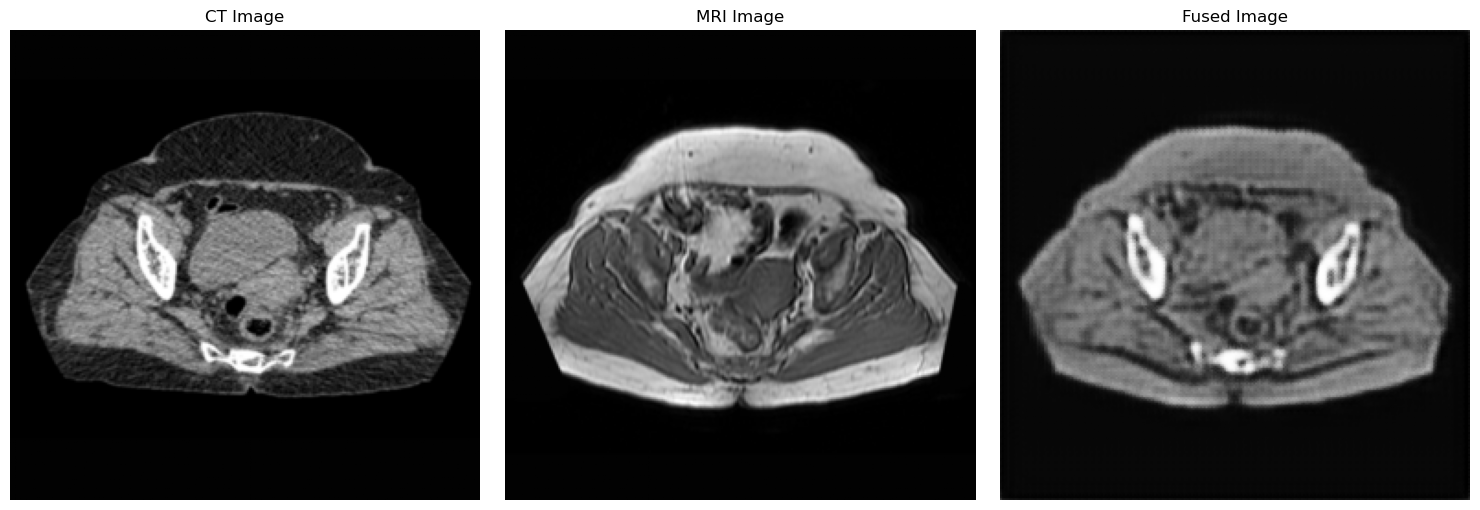

Demonstration completed! Image saved as 'results/ddcgan_fusion/test_demonstration.png'
Demonstration and testing complete!


In [11]:
print("Setting up demonstration and testing...")

def load_test_image_pair():
    """Load a sample CT and MRI image pair for testing"""
    # Create a simple test dataset
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    try:
        test_dataset = CTMRIDataset(DATASET_PATH, transform=test_transform, img_size=IMG_SIZE)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
        
        # Get one sample
        for ct_img, mri_img in test_loader:
            return ct_img, mri_img
    except:
        # Create dummy data if dataset is not available
        print("Using dummy data for demonstration")
        dummy_ct = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        dummy_mri = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        return dummy_ct, dummy_mri

def test_model(checkpoint_path=None):
    """Test the trained model on sample images"""
    # Create a simple generator for demonstration if no checkpoint is available
    generator = Generator(in_channels=2, out_channels=1).to(DEVICE)
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        try:
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            print(f"✓ Loaded model from {checkpoint_path}")
        except Exception as e:
            print(f"✗ Could not load model: {e}")
            print("Using untrained model for demonstration")
    else:
        print("No checkpoint provided. Using untrained model for demonstration.")
    
    # Set to evaluation mode
    generator.eval()
    
    # Load test images
    ct_img, mri_img = load_test_image_pair()
    ct_img = ct_img.to(DEVICE)
    mri_img = mri_img.to(DEVICE)
    
    # Create input by concatenating CT and MRI images
    input_img = torch.cat([ct_img, mri_img], dim=1)
    
    # Generate fused image
    with torch.no_grad():
        fused_img = generator(input_img)
    
    # Denormalize images for display
    ct_img_display = (ct_img.cpu().squeeze() + 1) / 2
    mri_img_display = (mri_img.cpu().squeeze() + 1) / 2
    fused_img_display = (fused_img.cpu().squeeze() + 1) / 2
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ct_img_display, cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    axes[1].imshow(mri_img_display, cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    axes[2].imshow(fused_img_display, cmap='gray')
    axes[2].set_title('Fused Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/test_demonstration.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Demonstration completed! Image saved as '{RESULTS_DIR}/test_demonstration.png'")

# Check for available checkpoints
checkpoint_files = []
if os.path.exists(CHECKPOINTS_DIR):
    checkpoint_files = [f for f in os.listdir(CHECKPOINTS_DIR) if f.endswith('.pth')]
if os.path.exists(FINAL_MODELS_DIR):
    checkpoint_files.extend([f for f in os.listdir(FINAL_MODELS_DIR) if f.endswith('.pth')])

if checkpoint_files:
    # Use the latest checkpoint
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(CHECKPOINTS_DIR if checkpoint_files[-1] in os.listdir(CHECKPOINTS_DIR) else FINAL_MODELS_DIR, 
                                    checkpoint_files[-1])
    print(f"Found checkpoint: {latest_checkpoint}")
    test_model(latest_checkpoint)
else:
    print("No checkpoints found. Running demonstration with untrained model.")
    test_model()

print("Demonstration and testing complete!")